In [1]:
WIDTH = 320
HEIGHT = 240
EPOCHS = 8
BATCH_SIZE = 2
TRAIN_CSV = "D:/kitti_dataset/train/kitti_train.csv"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

%run utils/datasets.ipynb
%run utils/utils.ipynb

In [3]:
partition, labels = load_train_csv(TRAIN_CSV)

In [4]:
# partition['train'] = partition['train'][:20000]
# partition['validation'] = partition['validation'][:5000]

In [5]:
print(len(partition['train']), len(partition['validation']))

4539 1135


In [6]:
training_generator = DataGenerator(list_IDs=partition['train'], labels=labels, batch_size=BATCH_SIZE,
                                   dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator = DataGenerator(list_IDs=partition['validation'], labels=labels, batch_size=BATCH_SIZE,
                                     dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [7]:
def downsampling_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
    x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = concatenate([x, concat_with], axis=3)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

In [8]:
def build(height, width, depth):
    # input
    i = Input(shape=(height, width, depth))

    # encoder
    conv1 = downsampling_block(i, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = downsampling_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = downsampling_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = downsampling_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # decoder
    conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
    conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
    conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
    conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)
    
    # output
    o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

    model = Model(inputs=i, outputs=o)
    return model

In [9]:
model = build(HEIGHT, WIDTH, 3)

In [10]:
# model.summary()

In [11]:
model.compile(optimizer=opt,
              loss=lambda y_true, y_pred : gen_depth_loss(y_true, y_pred, (1.0,1.0,0.1)),
              metrics=[depth_acc])

In [12]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LEARNING_RATE
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

In [13]:
r = model.fit(training_generator, validation_data=validation_generator,
              epochs=EPOCHS, callbacks=[LearningRateScheduler(poly_decay)])

Epoch 1/8
2269/2269 [==============================] - 305s 132ms/step - loss: 0.1476 - depth_acc: 0.9163 - val_loss: 0.1286 - val_depth_acc: 0.9315 - lr: 1.0000e-04
Epoch 2/8
2269/2269 [==============================] - 301s 133ms/step - loss: 0.1269 - depth_acc: 0.9361 - val_loss: 0.1225 - val_depth_acc: 0.9386 - lr: 8.7500e-05
Epoch 3/8
2269/2269 [==============================] - 305s 134ms/step - loss: 0.1231 - depth_acc: 0.9424 - val_loss: 0.1215 - val_depth_acc: 0.9422 - lr: 7.5000e-05
Epoch 4/8
2269/2269 [==============================] - 309s 136ms/step - loss: 0.1210 - depth_acc: 0.9455 - val_loss: 0.1198 - val_depth_acc: 0.9465 - lr: 6.2500e-05
Epoch 5/8
2269/2269 [==============================] - 307s 135ms/step - loss: 0.1200 - depth_acc: 0.9466 - val_loss: 0.1169 - val_depth_acc: 0.9449 - lr: 5.0000e-05
Epoch 6/8
2269/2269 [==============================] - 307s 135ms/step - loss: 0.1184 - depth_acc: 0.9500 - val_loss: 0.1170 - val_depth_acc: 0.9458 - lr: 3.7500e-05
Epoc

In [14]:
print(r.history)

{'loss': [0.14759553968906403, 0.12690699100494385, 0.12312936037778854, 0.1209644004702568, 0.1200246512889862, 0.11839473992586136, 0.11684003472328186, 0.11587797105312347], 'depth_acc': [0.9162894487380981, 0.9360592365264893, 0.9423869848251343, 0.9455371499061584, 0.9465516209602356, 0.9500418901443481, 0.9528895616531372, 0.9545711278915405], 'val_loss': [0.12863679230213165, 0.12248637527227402, 0.12147206813097, 0.1197609081864357, 0.11689545959234238, 0.11698704957962036, 0.11410137265920639, 0.11354225128889084], 'val_depth_acc': [0.9314936995506287, 0.9386388063430786, 0.9421502947807312, 0.9464651942253113, 0.9448509216308594, 0.9457865953445435, 0.9544270038604736, 0.9531856179237366], 'lr': [1e-04, 8.75e-05, 7.5e-05, 6.25e-05, 5e-05, 3.75e-05, 2.5e-05, 1.25e-05]}


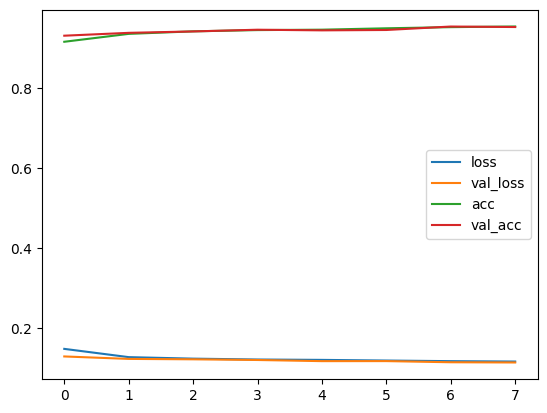

In [15]:
plot_history(r.history)

In [16]:
print(save_model('kitti_unet', model))

model_kitti_unet_1709064377.keras
